# Load the data & Package installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from zipfile import ZipFile
from collections import Counter
import seaborn as sns
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
%matplotlib inline

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [5]:
with ZipFile('/content/drive/MyDrive/ydata/house-prices-regression-predictions-ydata.zip', 'r') as zObject:
  zObject.extractall(
        path="/content/sample_data/data/")

In [6]:
train_data = pd.read_csv("/content/sample_data/data/train.csv")
test_data = pd.read_csv("/content/sample_data/data/test.csv")

# Exploratory data analysis

## Missing values

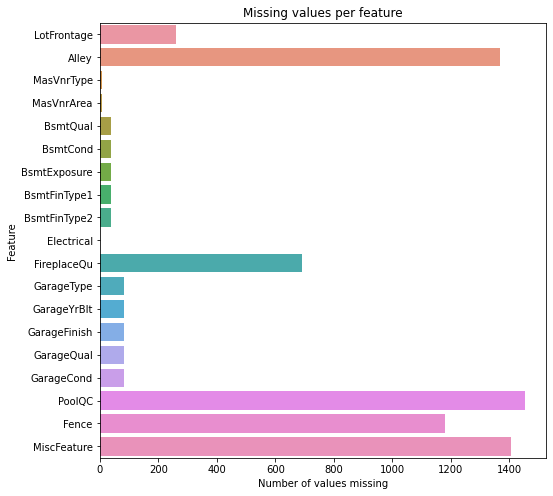

In [7]:
missing_values = train_data.isna().sum(axis=0)
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(8,8))
sns.barplot(y=missing_values.keys(), x=missing_values.values)
plt.title("Missing values per feature")
plt.xlabel("Number of values missing")
plt.ylabel("Feature");


The features with the highest number of missing values are Alley, PoolQC, Fence, MiscFeature. From reading the data description we understand that the missing values are because the houses don't have the feature attribute, there for we fill the values with 0 to numeric features and with 'NA' for categorical attributes.

In [8]:
MISSING_VALUES_FEATURES = ['PoolQC', 'Alley', 'FireplaceQu', 'Fence', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
def fill_missing_values(df):
  df_fill = df.copy()
  df_fill[MISSING_VALUES_FEATURES] = df_fill.loc[:, MISSING_VALUES_FEATURES].fillna("NA")
  df_fill[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']] = df_fill[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].fillna(0.0)
  df_fill['MasVnrType'] = df_fill['MasVnrType'].fillna('None')
  # fill electrical missing values with most common value
  df_fill['Electrical'] = df_fill['Electrical'].fillna('SBrkr')
  return df_fill

train_fill_missing_values = fill_missing_values(train_data)

# House prices over the years

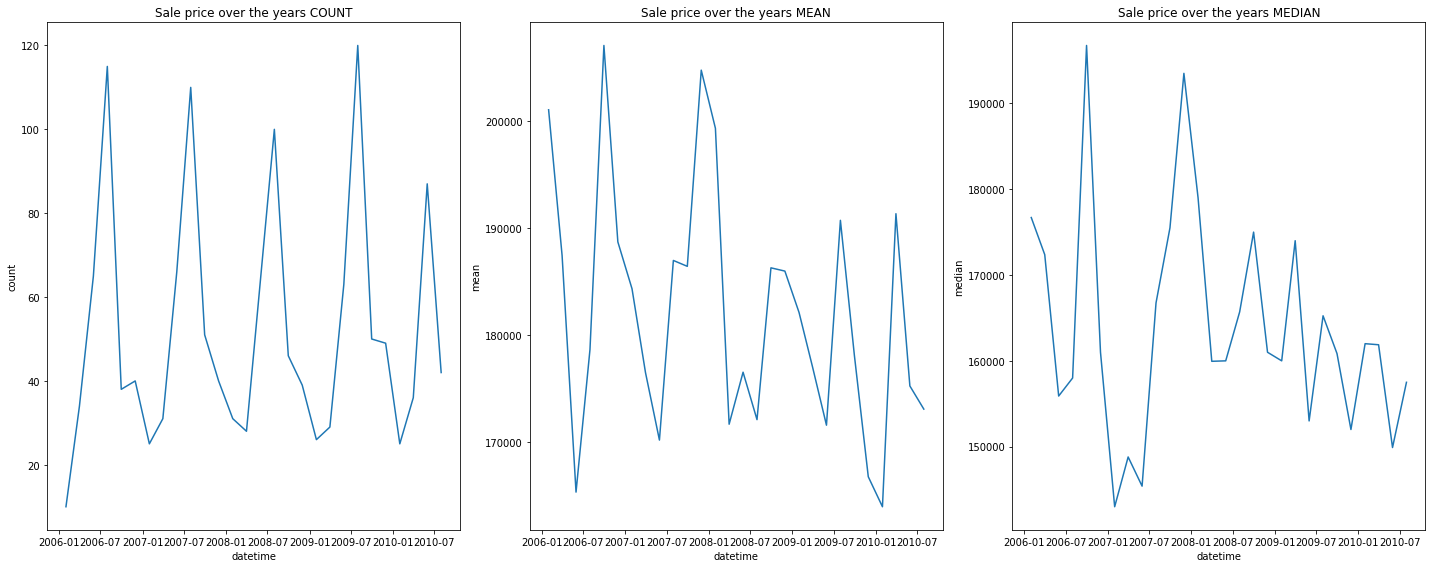

In [9]:
import datetime

train_fill_missing_values['datetime'] = train_fill_missing_values.apply(lambda r: pd.to_datetime(datetime.date(year=r['YrSold'], month=r['MoSold'], day=15)), axis=1 )
resample_data = train_fill_missing_values.resample(rule="2M", on="datetime")['SalePrice'].aggregate(["count", "mean", "median"])
resample_data['Month'] = resample_data.index.month
resample_data['Year'] = resample_data.index.year


plt.subplots(1,3, figsize=(20,8))
plot_index = 0

for i, col in enumerate(["count", "mean", "median"]):
  plt.subplot(1, 3, i+1)
  sns.lineplot(data=resample_data, x=resample_data.index, y=col)
  plt.title(f"Sale price over the years {col.upper()}")
  plot_index +=1
  
plt.tight_layout()

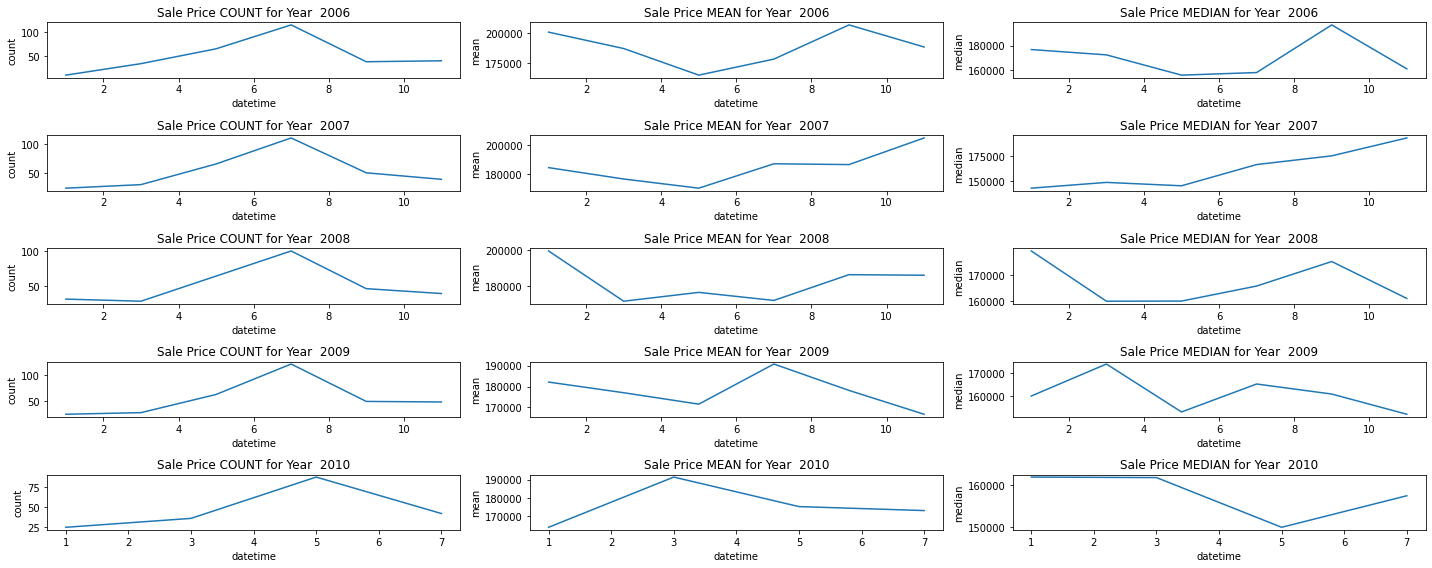

In [10]:
plt.subplots(1,3, figsize=(20,8))
plot_index = 0

for year in resample_data.index.year.unique().sort_values():
  ts_data = resample_data[resample_data.index.year == year]
  for i, col in enumerate(["count", "mean", "median"]):
    plt.subplot(5, 3, plot_index+ 1)
    sns.lineplot(x=ts_data.index.month, y= ts_data[col])
    plt.title(f"Sale Price {col.upper()} for Year  {year}")
    plot_index +=1
  
plt.tight_layout()

We can see that the number of houses that are sold has an annual cycle. More houses are sold in the middle of the year (Jun-Aug) than any other time, but we can't see that it's influence the house prices. 

## Features distributions

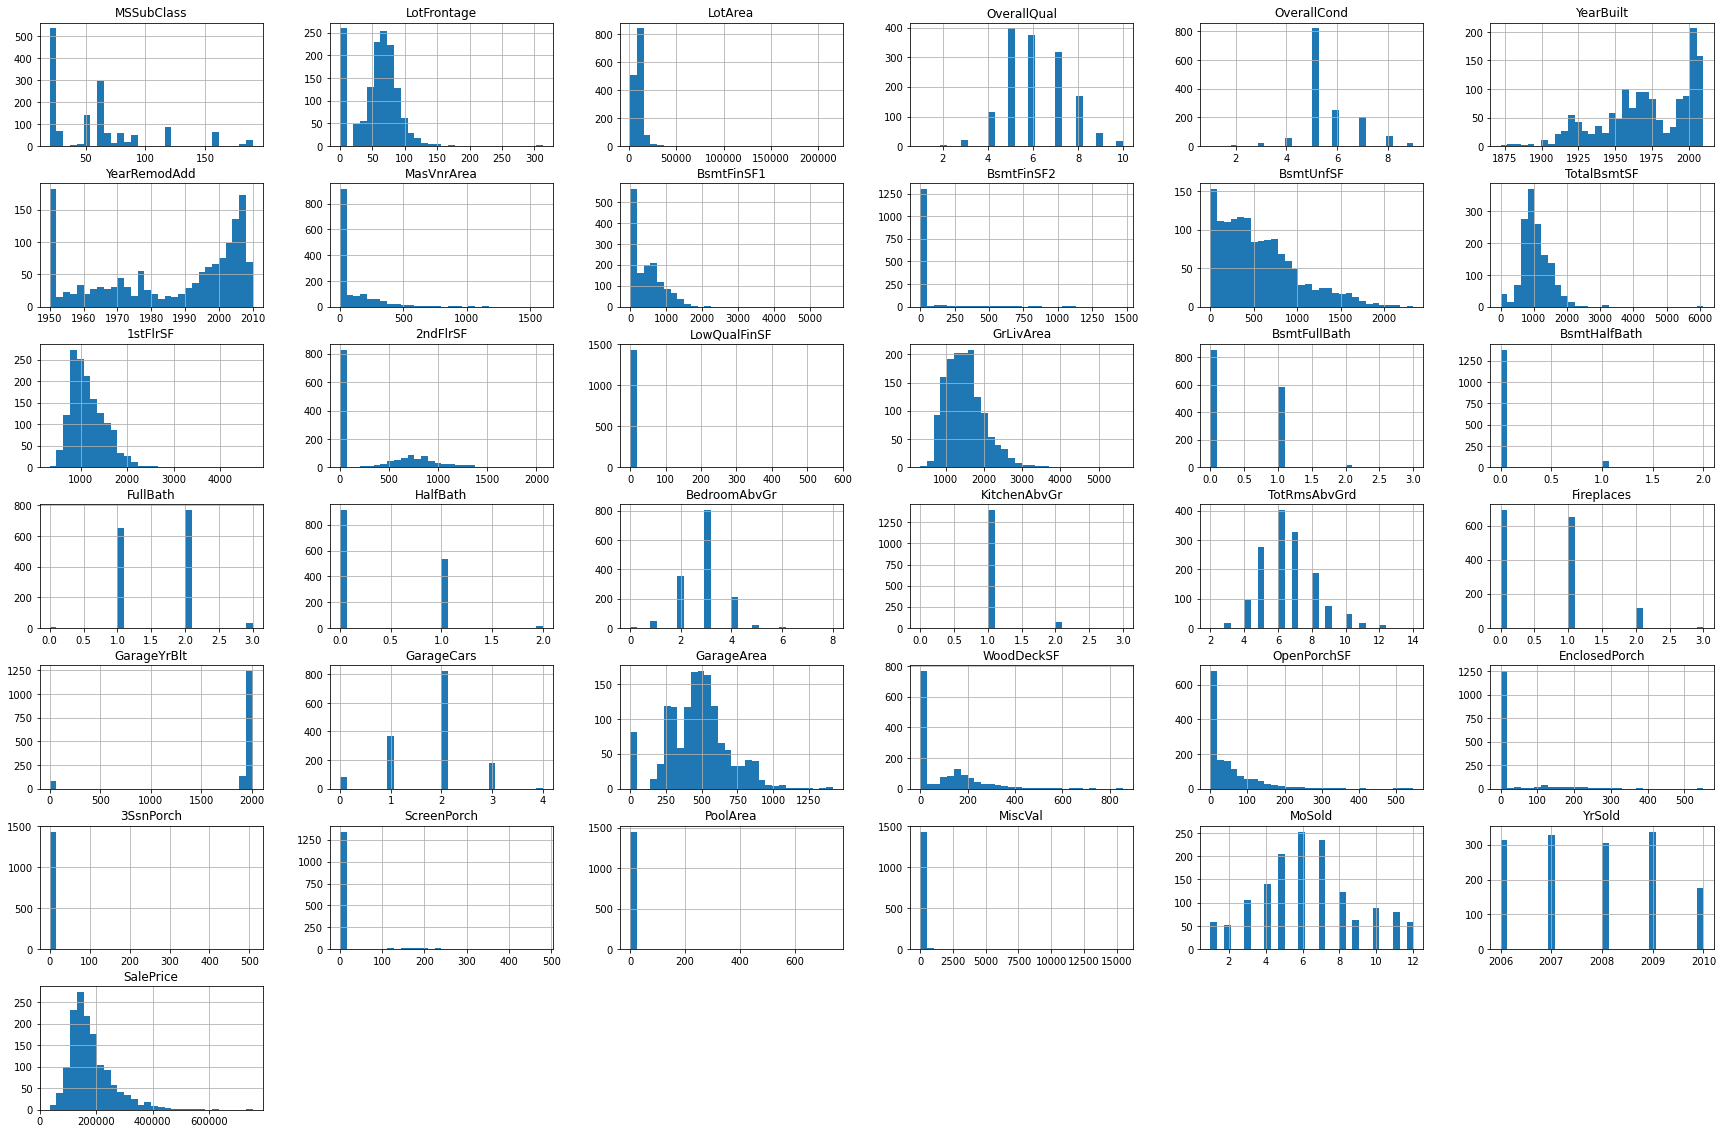

In [11]:
train_fill_missing_values.drop(['Id', 'datetime'], axis=1).hist(bins = 30, figsize=(30, 20))
plt.show()

Numeric Features correlation

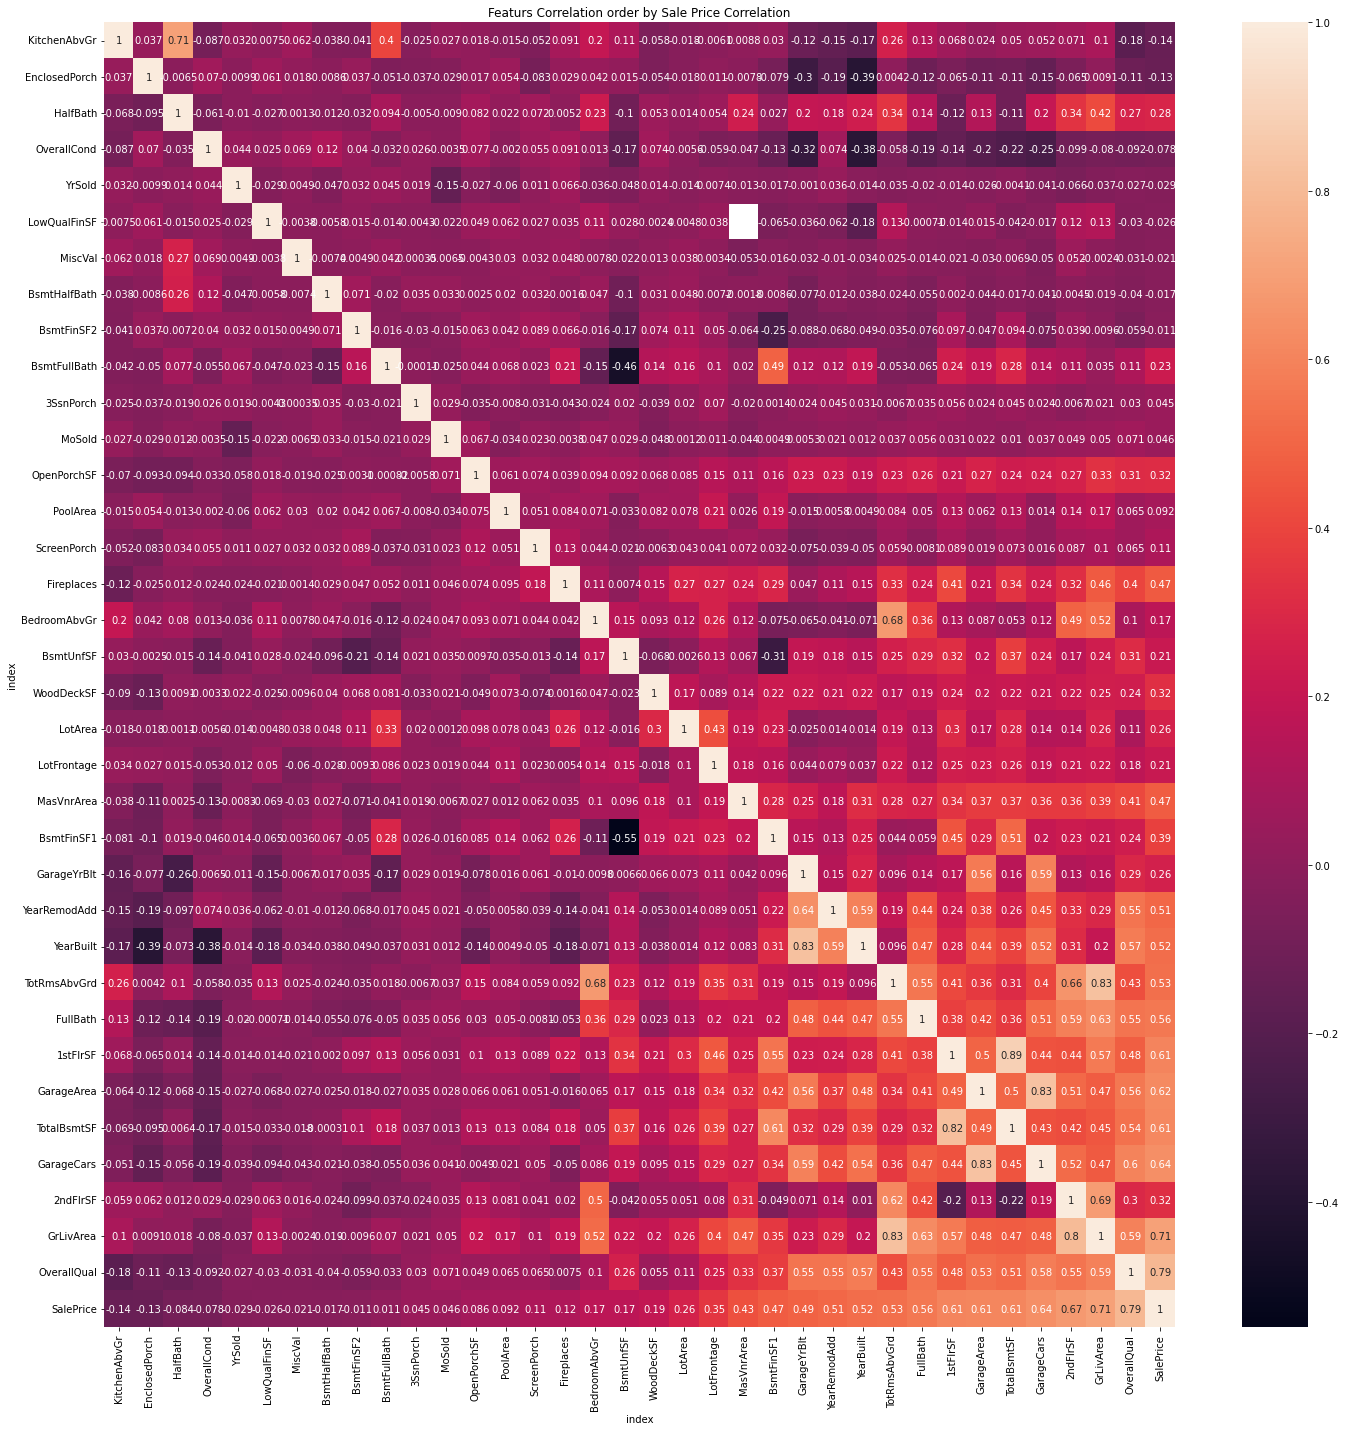

In [12]:
def clean_correlation(data, ignored_columns):
  features_correlation = {}
  numeric_features = data.columns
  for feature in data.columns:
    clean_data = data
    if clean_data[feature].dtype == 'O':
      continue
    if feature in ignored_columns:
      clean_data = data[data[feature] > 0]
    feature_corr = clean_data.corr()
    feature_corr = feature_corr.loc[:, feature]
    features_correlation[feature]= feature_corr
  correlation_df = pd.concat(features_correlation, axis=1, ignore_index=True, keys=features_correlation.keys())
  correlation_df.columns = correlation_df.index
  return correlation_df

column_zero_counts = (train_fill_missing_values == 0).sum()
column_zero_counts = column_zero_counts[(column_zero_counts> 30) & (column_zero_counts < 1000) ]

clean_correlation = clean_correlation(train_fill_missing_values.drop(['Id', 'MSSubClass', 'datetime'], axis=1), column_zero_counts)

# sort the correlation df by Sale Price 
saleprice_corr  = clean_correlation.loc['SalePrice', :].sort_values().reset_index().set_index(['index'])
clean_correlation = clean_correlation.loc[saleprice_corr.index, saleprice_corr.index]
# plot correlation
plt.figure(figsize=(24, 24))
sns.heatmap(clean_correlation, annot=True)
plt.title("Featurs Correlation order by Sale Price Correlation");

To get more accurate correlation, we drop the samples to features that has high number of zeros, we calculate correlation for each feature and then combine the results to correlation dataframe.

We can see that the most correlated features to Sale Price are OverallQual, GrlivArea, 2ndFlrSF, GarageCars, 1stFlrSF. 
We can see that some of the most correlaetd featuers has high correlation between them, for example:

  *  GrLivArea , 2ndFlrSF : 0.8
  *  GarageCars, GarageArea : 0.83
  *  GrLivArea, TotRmsAbvGrd : 0.83
  *  GarageArea, TotalBsmtSF: 0.89





In [13]:
def plot_features_scatterplot(agg_data,agg_features, nrows, ncol, fig_size=(16,6)):

  fig, ax = plt.subplots(nrows, ncol, figsize=fig_size)

  for index in range(len(agg_features)):
    plt.subplot(nrows, ncol, index+1)
    feature_name = agg_features[index]
    sns.scatterplot(data=agg_data, x=feature_name, y='SalePrice')
    plt.title(f"Sale price based on {feature_name}", fontsize=12)

  plt.tight_layout();


def plot_features_boxenplot(agg_data, agg_features, nrows, ncol, order=None, fig_size=(16,6)):
  fig, ax = plt.subplots(nrows,ncol,figsize=fig_size)

  for index in range(len(agg_features)):
    plot_order = None
    plt.subplot(nrows,ncol,index+1)
    feature_name = agg_features[index]
    if (not order is None) and (len(set(QUALITY_ORDER) & set(agg_data[feature_name].values)) > 0):
      plot_order = order
    sns.boxenplot(data=agg_data, x=feature_name, y='SalePrice', order = plot_order)
    plt.title(f"Sale price based on High quality {feature_name}", fontsize=12)

  plt.tight_layout();

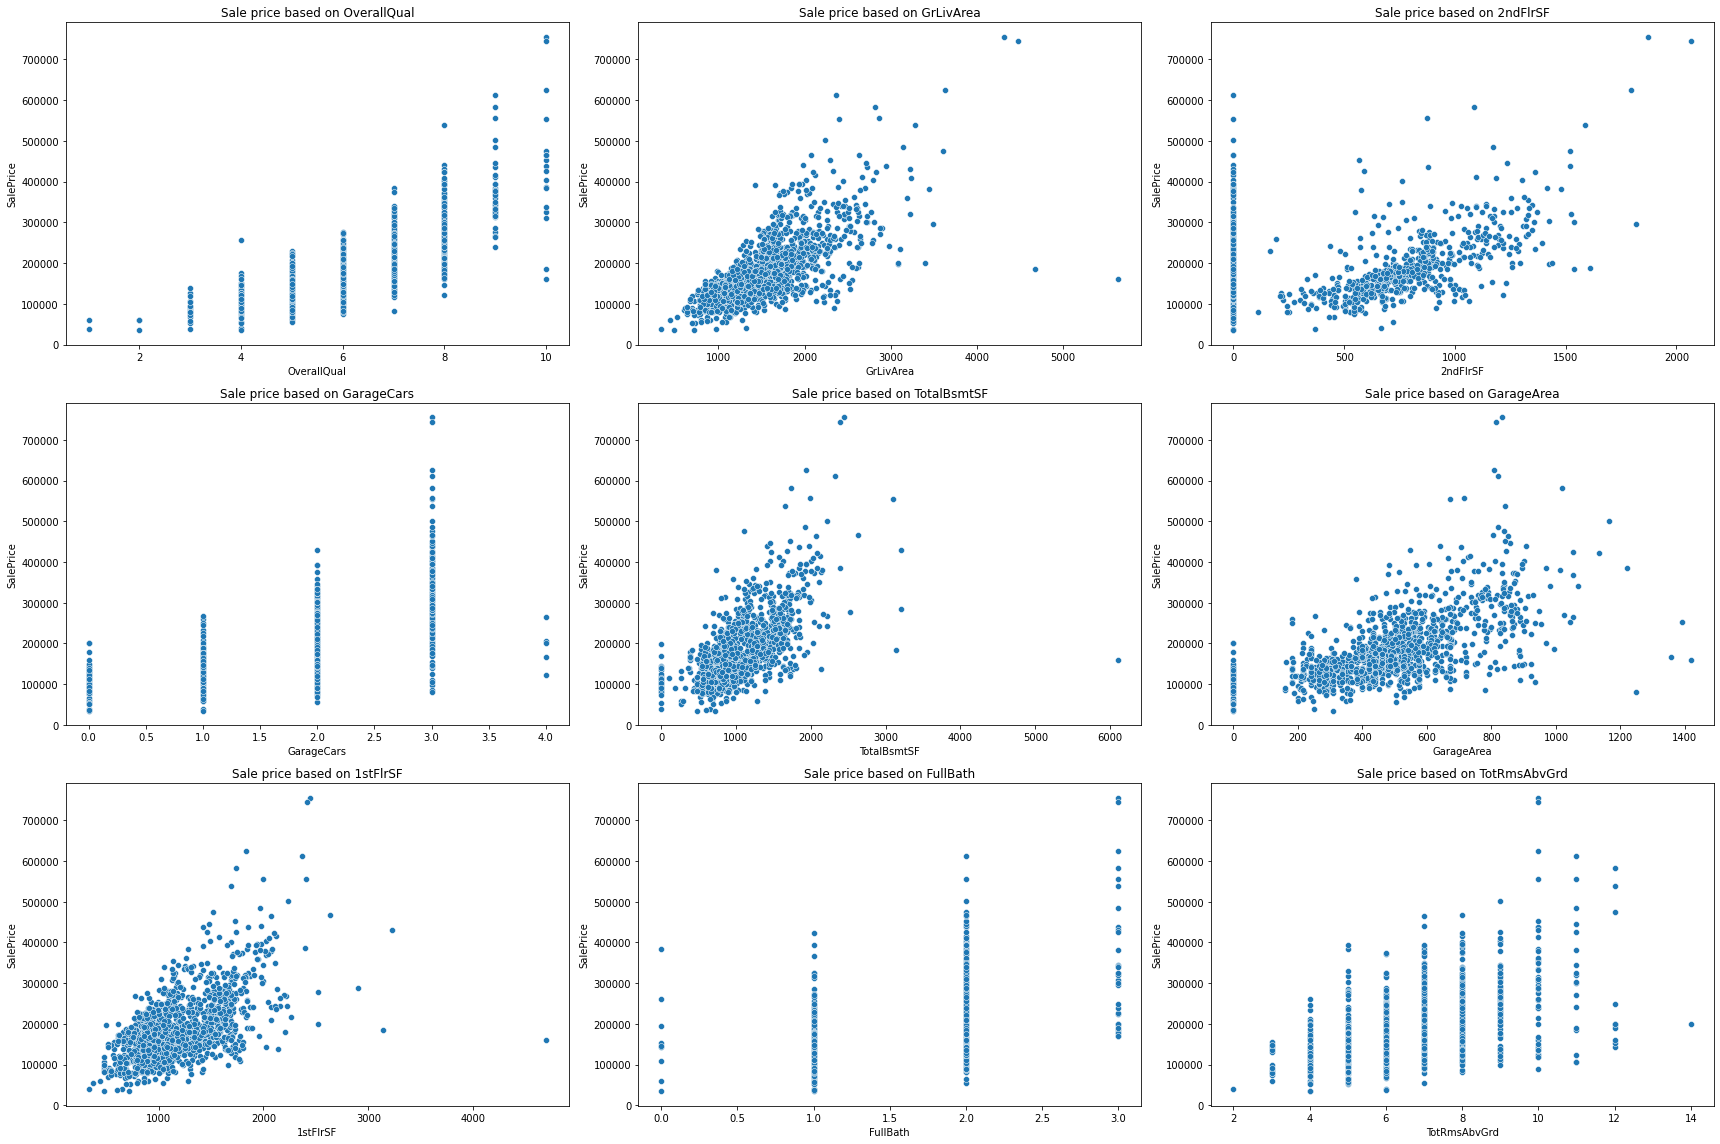

In [14]:
top_correlated_features = list(saleprice_corr[-10: -1].index)

top_correlated_features.reverse()
plot_features_scatterplot(train_fill_missing_values, top_correlated_features, 3, 3, fig_size=(24,16))

## Categorical Features

### Quality features 

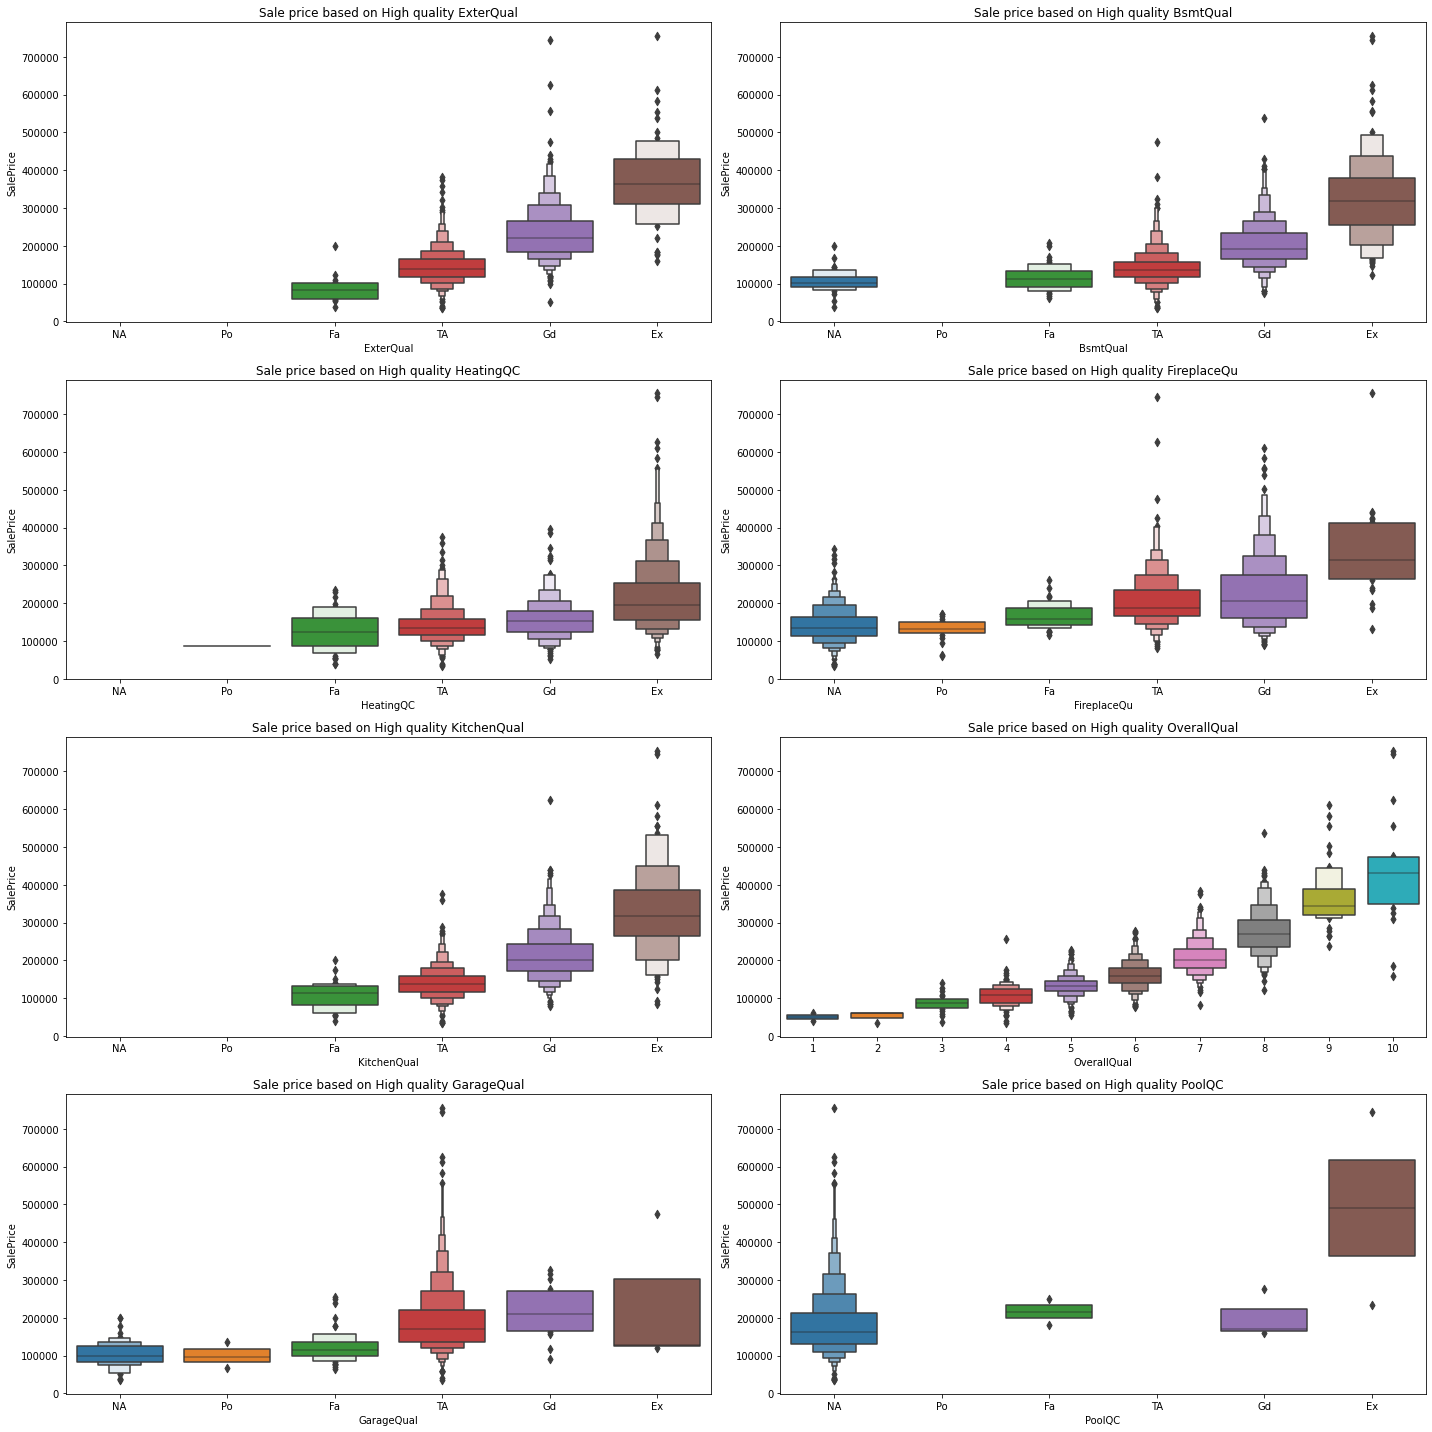

In [15]:
QUALITY_FEATURES = ['ExterQual', 'BsmtQual', 'HeatingQC', 'FireplaceQu', 'KitchenQual', 'OverallQual', 'GarageQual', 'PoolQC']
QUALITY_ORDER = ["NA","Po", "Fa", "TA", "Gd", "Ex"]

plot_features_boxenplot(train_fill_missing_values, QUALITY_FEATURES, 4, 2, QUALITY_ORDER, fig_size=(20,20))

We can see that some of the house quality features as good information about the house sale price. The features that looks like have good releation to the house price are ExterQual, BsmtQual, KitchenQual and OverallQual.

We can see that for most of the houses there is no pool.
For some of the features there is partial relation between the quality to the house price, for example for HeatingQC the sale price is higher only for houses houses with excellent quality, but for the other qualites the sale price don't change to much.

We can also see that for many quality features on the training data does not contains poor quality.

### Other relevant Categorical Features

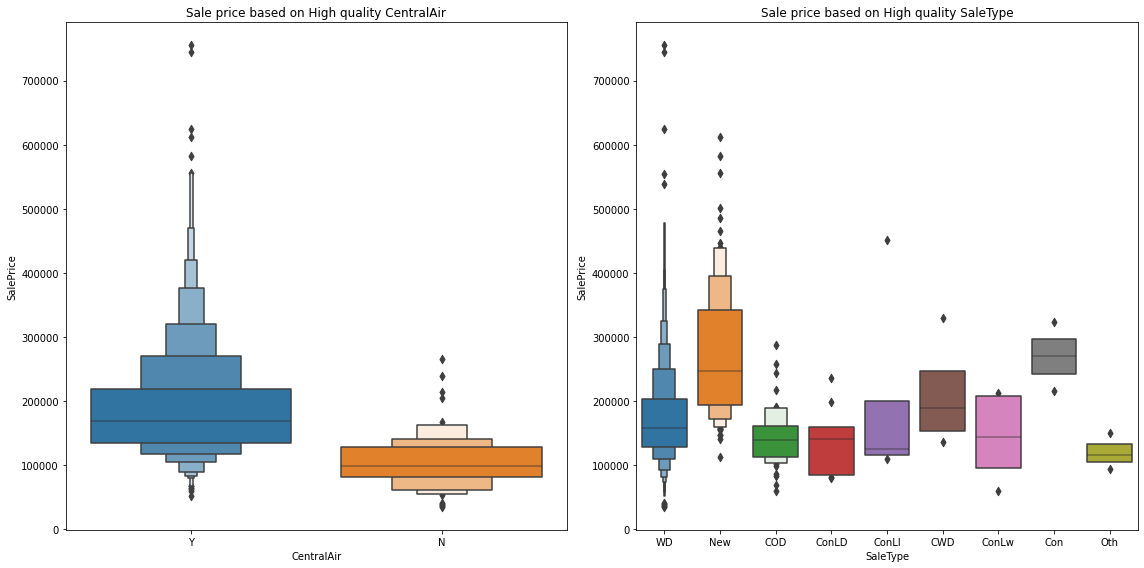

In [16]:
IMPORTANT_FEATURES =  ['CentralAir', 'SaleType']

plot_features_boxenplot(train_fill_missing_values, IMPORTANT_FEATURES, 1,2, fig_size=(16,8))

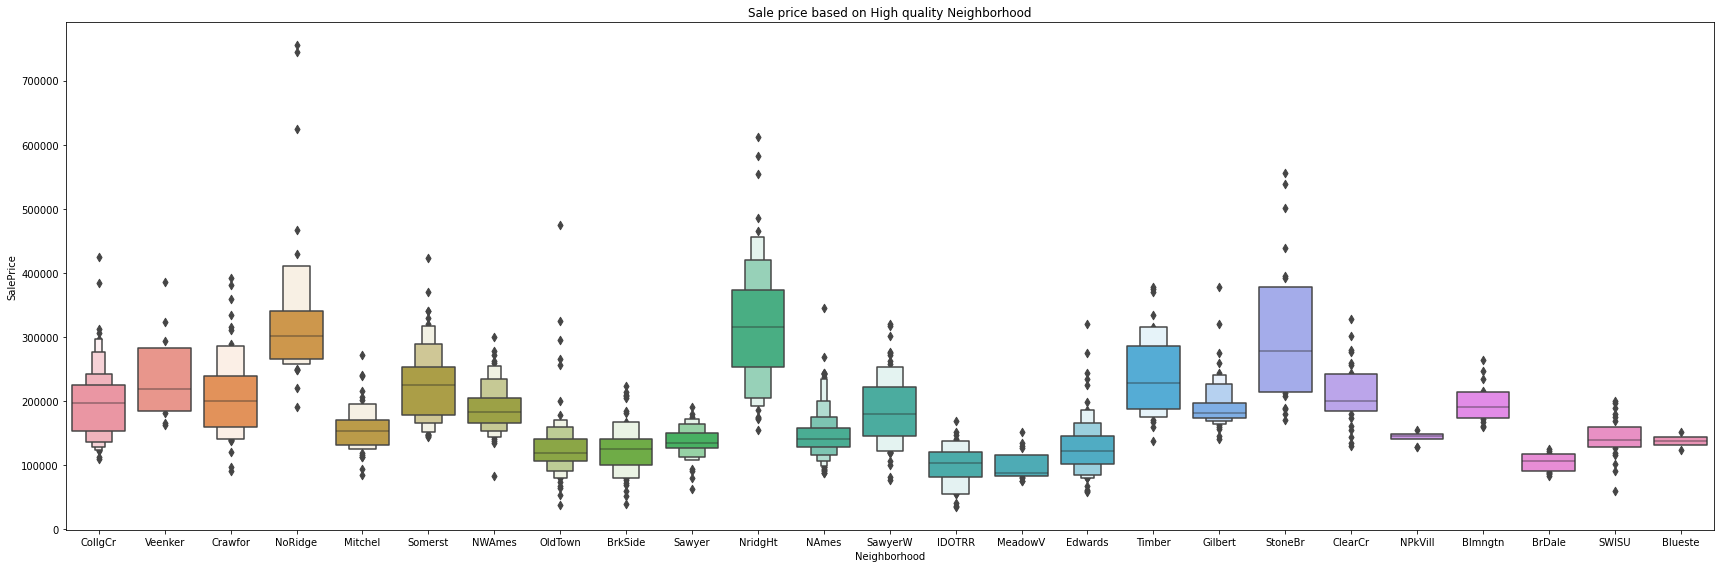

In [17]:


plot_features_boxenplot(train_fill_missing_values, ['Neighborhood'], 1,1, fig_size=(24,8))


## Outliers

We can see from the plots that some samples are outliers, for example we can see that for GrLivArea there are 2 samples with high value but with low Sale Price. In addition we can see 2 samples with high OverallQual (10) but with low Sale Price.

In addition, the amount of data is relatively small, therefor aggregation of the data can help us to avoid overfitting 

# Data Processing

### Drop outliers

In [228]:
outliers_GrLivArea = train_fill_missing_values[(train_fill_missing_values.GrLivArea > 4000) & (train_fill_missing_values.SalePrice < 200000)].index
outliers_PoolQC = train_fill_missing_values[(train_fill_missing_values.PoolQC == 'Ex') & (train_fill_missing_values.SalePrice > 500000)].index

out_index = [*outliers_PoolQC, *outliers_GrLivArea]

train = train_fill_missing_values.drop(out_index, axis=0)

out_index

[1182, 523, 1298]

### Drop unnecessaries features

In [229]:
train.drop(['datetime', 'Id', 'LotFrontage', 'Utilities'], inplace=True, axis=1)
train.loc[train['LotArea'] > 30000, 'LotArea'] = 30000

### Map Categorical values to Ordinal values

In [230]:
# map quality features

mapping = {'NA': 0, 
           'Po': 1, 
           'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

for col in train.columns:
    if train[col].unique().any() in ['TA', 'Gd', 'Fa', 'Po', 'Ex']:
        train[col] = train[col].map(mapping)

train['FireplaceQu'] = train['FireplaceQu'].map(mapping)


In [231]:
# map neighborhoods 


neighborhoods = (train.groupby('Neighborhood')['SalePrice']
                 .agg(['mean', 'median', 'count'])
                 .sort_values(by='median', ascending=False))

n_sorted = neighborhoods.sort_values(by='median').index


for i, n in enumerate(n_sorted):
    train.loc[train['Neighborhood'] == n, 'NeighborhoodOrdinal'] = int(i+1)

train

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,NeighborhoodOrdinal
0,60,RL,8450,Pave,NA,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,GLQ,706,Unf,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,NA,NA,NaN,0,2,2008,WD,Normal,208500,17.0
1,20,RL,9600,Pave,NA,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,ALQ,978,Unf,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,NA,NA,NaN,0,5,2007,WD,Normal,181500,20.0
2,60,RL,11250,Pave,NA,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,GLQ,486,Unf,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,NA,NA,NaN,0,9,2008,WD,Normal,223500,17.0
3,70,RL,9550,Pave,NA,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,No,ALQ,216,Unf,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,NA,NA,NaN,0,2,2006,WD,Abnorml,140000,19.0
4,60,RL,14260,Pave,NA,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,Av,GLQ,655,Unf,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,NA,NA,NaN,0,12,2008,WD,Normal,250000,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,NA,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,Unf,0,Unf,0,953,953,GasA,5,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,3,7,Typ,1,3,Attchd,1999.0,RFn,2,460,3,3,Y,0,40,0,0,0,0,NA,NA,NaN,0,8,2007,WD,Normal,175000,14.0
1456,20,RL,13175,Pave,NA,Reg,Lvl,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,3,3,CBlock,4,3,No,ALQ,790,Rec,163,589,1542,GasA,3,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,3,7,Min1,2,3,Attchd,1978.0,Unf,2,500,3,3,Y,349,0,0,0,0,0,NA,MnPrv,NaN,0,2,2010,WD,Normal,210000,15.0
1457,70,RL,9042,Pave,NA,Reg,Lvl,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,5,4,Stone,3,4,No,GLQ,275,Unf,0,877,1152,GasA,5,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,4,9,Typ,2,4,Attchd,1941.0,RFn,1,252,3,3,Y,0,60,0,0,0,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500,19.0
1458,20,RL,9717,Pave,NA,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,3,3,Mn,GLQ,49,Rec,1029,0,1078,GasA,4,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,4,5,Typ,0,0,Attchd,1950.0,Unf,1,240,3,3,Y,366,0,112,0,0,0,NA,NA,NaN,0,4,2010,WD,Normal,142125,10.0


# Modeling

In [232]:
def model_evaluation(estimator, train_X, train_y, test_X, test_y, estimator_Name=""):
  estimator.fit(train_X, train_y)

  estimator_test_predictions = base_estimator.predict(test_X)
  estimator_test_mae = mean_absolute_error(test_y, estimator_test_predictions)

  estimator_train_predictions = base_estimator.predict(train_X)
  estimator_train_mae = mean_absolute_error(train_y, estimator_train_predictions)
  print(f"{estimator_Name} Estimator Train MAE {estimator_train_mae}")
  print(f"{estimator_Name} Estimator Test MAE {estimator_test_mae}")


# Basic Model

In [169]:
from sklearn.tree import DecisionTreeRegressor

train_labels = train['SalePrice']
train_features = train.drop(['SalePrice'], axis=1)

categorical_features = train_features.columns[train_features.dtypes == 'object']
train_features = pd.get_dummies(data=train_features.loc[:, categorical_features], columns=categorical_features)

base_estimator_train_X, base_estimator_test_X, base_estimator_train_y, base_estimator_test_y = train_test_split(train_features, train_labels, test_size=0.25, random_state=42)

base_estimator = DecisionTreeRegressor(min_samples_split=20)

model_evaluation(base_estimator, base_estimator_train_X, base_estimator_train_y, base_estimator_test_X, base_estimator_test_y, "DecisionTreeRegressor")


DecisionTreeRegressor Estimator Train MAE 20518.776367233644
DecisionTreeRegressor Estimator Test MAE 36408.42359348779


## CatBoost Model

In [233]:
def extract_cat_features(data):
    cat_features = []
    num_features = []
    for i, col in enumerate(data.columns):
        if data[col].dtype == 'object':
            cat_features.append(col)
        else:
            num_features.append(col)
    return cat_features, num_features


def prepare_and_split_data(input_data, test_size=0):
    data = input_data.copy()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col].fillna('N_A', inplace=True)
        else:
            data[col].fillna(0, inplace=True)
    X = data.drop('SalePrice', axis=1)
    y = data['SalePrice']
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [234]:
cat_features, num_features = extract_cat_features(train)
X_train, X_test, y_train, y_test = prepare_and_split_data(train, test_size=.25)
X_train.shape

(1092, 78)

In [238]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=2, 
                          learning_rate=0.1, 
                          loss_function='MAE',
                          l2_leaf_reg=5,
                          one_hot_max_size=30,
                          random_state=42,
                          random_strength=1,                          
                          verbose=100
                          )
#train the model
model.fit(train_pool, eval_set=eval_pool)
# make the prediction using the resulting model
preds = model.predict(eval_pool)



0:	learn: 52310.3625933	test: 52195.5670789	best: 52195.5670789 (0)	total: 1.05ms	remaining: 1.04s
100:	learn: 15297.0250604	test: 15690.9122150	best: 15690.9122150 (100)	total: 89.8ms	remaining: 799ms
200:	learn: 12879.7956265	test: 14277.6429289	best: 14267.7958799 (197)	total: 175ms	remaining: 697ms
300:	learn: 11945.7039739	test: 13925.5960802	best: 13861.7748183 (290)	total: 268ms	remaining: 623ms
400:	learn: 11233.7435121	test: 13675.6768669	best: 13675.6768669 (400)	total: 357ms	remaining: 533ms
500:	learn: 10634.5988017	test: 13716.0626875	best: 13640.7573667 (414)	total: 445ms	remaining: 443ms
600:	learn: 10231.2539262	test: 13694.3550675	best: 13640.7573667 (414)	total: 549ms	remaining: 365ms
700:	learn: 9944.6832607	test: 13748.6856069	best: 13640.7573667 (414)	total: 651ms	remaining: 277ms
800:	learn: 9642.8184246	test: 13733.9889787	best: 13640.7573667 (414)	total: 744ms	remaining: 185ms
900:	learn: 9447.8183621	test: 13728.9695274	best: 13640.7573667 (414)	total: 830ms	re

In [239]:
print(f'RMSE: {np.sqrt(mean_squared_error(preds, y_test))}')
print(f'MAE: {mean_absolute_error(preds, y_test)}')
print(f'LRMSE: {np.sqrt(mean_squared_log_error(preds, y_test))}')


RMSE: 20007.071276807543
MAE: 13640.757367715576
LRMSE: 0.1178525150133027


### Error Analysis

In [240]:
def error_analysis(labels, predictions):
  plt.subplots(1,2, figsize=(20, 12))

  # Prediction vs Labels plot
  plt.subplot(1,2,1)
  line_plot_data = np.linspace(0, 500000, 100)
  sns.scatterplot(x=predictions, y=labels)
  sns.lineplot(x=line_plot_data, y=line_plot_data)
  plt.xlabel('SalePrice predicted')
  plt.ylabel('SalePrice label')
  plt.title("Sale price pridected vs label");

  # Diff plot 
  plt.subplot(1,2,2)
  sns.scatterplot(range(len(preds)), (preds - y_test))
  plt.axhline(0, c='r')
  plt.axhline(20000, c='g')
  plt.axhline(-20000, c='g')
  plt.title("Residuals plot")
  plt.ylabel("SalePrice diff")
  plt.suptitle("Error Analysis", fontsize=20)
  plt.tight_layout();


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


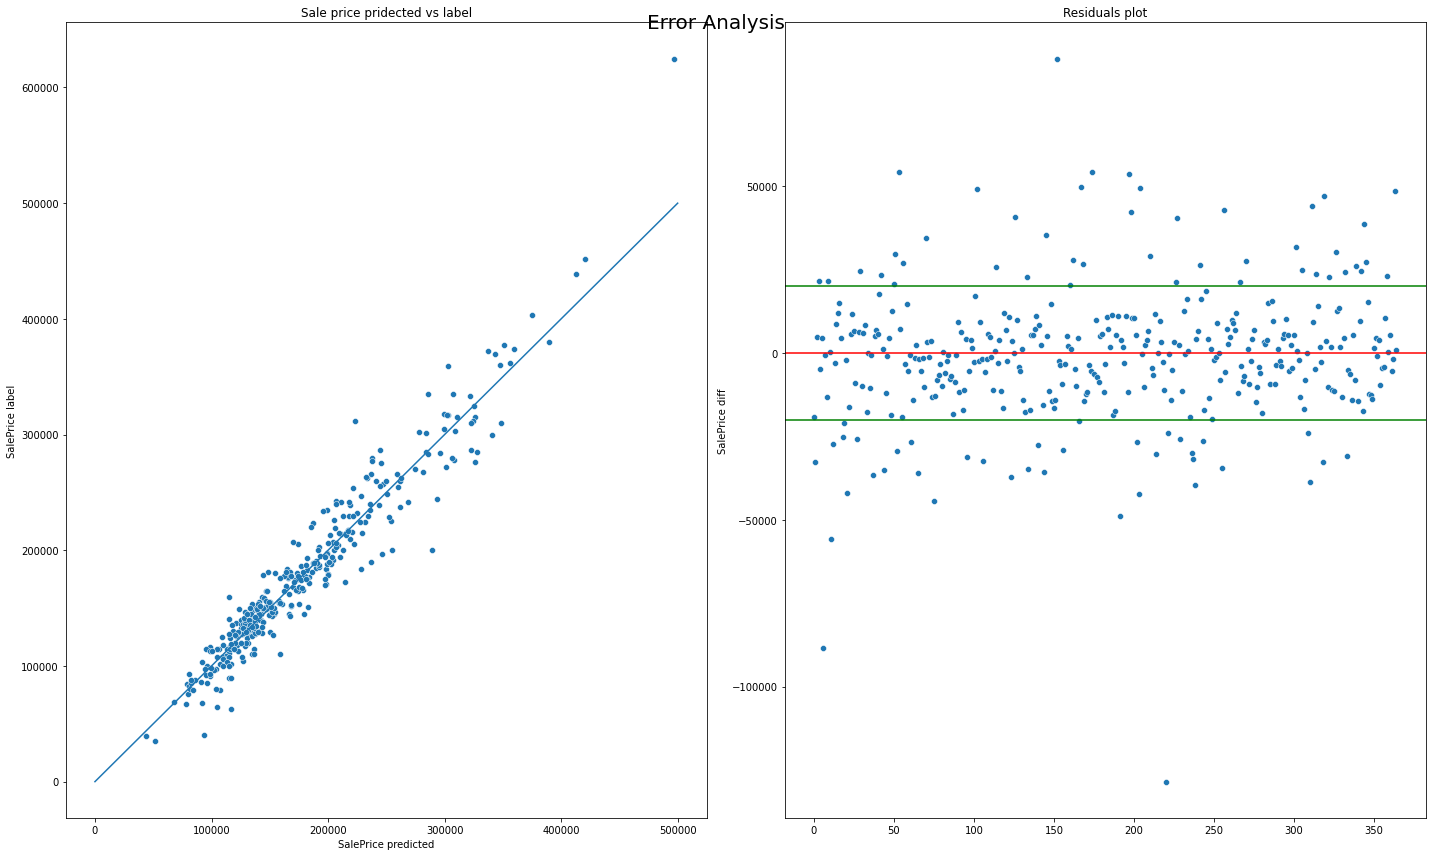

In [241]:
error_analysis(y_test, preds)


## Feature importance

In [242]:
catboost_feature_importance = pd.DataFrame({"importance": model.feature_importances_, "feature": model.feature_names_}).sort_values(by="importance", ascending=False)
catboost_feature_importance

,importance,feature
14,18.116044,OverallQual
43,16.329403,GrLivArea
77,12.362437,NeighborhoodOrdinal
35,8.109760,TotalBsmtSF
24,6.156370,ExterQual
59,4.559749,GarageArea
58,4.239752,GarageCars
50,4.154520,KitchenQual
31,4.130365,BsmtFinSF1
40,2.572501,1stFlrSF


# Model Improvements

### Features Aggregations

In [308]:
train_aggregation = train.copy()

outliers_GarageArea = train_aggregation[(train_aggregation.GarageArea > 1200) & (train_aggregation.SalePrice < 200000)].index
outliers_OverallQual = train_aggregation[(train_aggregation.OverallQual == 4) & (train_aggregation.SalePrice > 200000)].index
outliers_TotRmsAbvGrd = train_aggregation[(train_aggregation.TotRmsAbvGrd > 12)].index

out_index = [*outliers_GarageArea, *outliers_OverallQual, *outliers_TotRmsAbvGrd]

out_index

[1061, 1190, 457, 635]

We drop  more samples that we decided that are outliers.





### Features Selection

In [304]:
train_aggregation['GarageCars'] = train_aggregation['GarageCars'].apply(lambda x: x if x <=3 else 3).astype(int)
train_aggregation['Fireplaces'] = train_aggregation['Fireplaces'].apply(lambda x: x if x <=3 else 3).astype(int)
train_aggregation.drop([*(catboost_feature_importance['feature'][-20:])], axis=1, inplace=True)
train_aggregation.drop(['GarageArea', 'TotRmsAbvGrd' ,'BsmtFinType2', 'Condition2', 'MasVnrType', '3SsnPorch'], axis=1, inplace=True)

We drop GarageArea, TotRmsAbvGrd because they have high correlation with GarageCars and GrLivArea. 

We drop the other features, because they had weak importance and without them the validation results was improved. 

## Catboost with feature aggregation

In [300]:
cat_features, num_features = extract_cat_features(train_aggregation)
X_train, X_test, y_train, y_test = prepare_and_split_data(train_aggregation, test_size=.25)


# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)


# specify the training parameters 
model = CatBoostRegressor(iterations=5000, 
                          depth=2, 
                          bootstrap_type="MVS",
                          grow_policy='SymmetricTree',
                          learning_rate=0.1, 
                          loss_function='MAE',
                          min_child_samples=50,
                          l2_leaf_reg=25,
                          one_hot_max_size=30,
                          random_state=42,
                          random_strength=1,                          
                          verbose=100
                          )
#train the model
model.fit(train_pool, eval_set=eval_pool)
# make the prediction using the resulting model
preds = model.predict(eval_pool)

0:	learn: 52310.3625933	test: 52195.5670789	best: 52195.5670789 (0)	total: 941us	remaining: 4.71s
100:	learn: 15061.6955789	test: 15783.7655822	best: 15783.7655822 (100)	total: 74ms	remaining: 3.59s
200:	learn: 12907.2962624	test: 14569.2244173	best: 14569.2244173 (200)	total: 153ms	remaining: 3.66s
300:	learn: 11958.3328968	test: 14245.9794032	best: 14245.2698191 (299)	total: 230ms	remaining: 3.59s
400:	learn: 11244.5451014	test: 14343.6303840	best: 14217.9890160 (318)	total: 309ms	remaining: 3.54s
500:	learn: 10756.6968992	test: 14401.7203119	best: 14217.9890160 (318)	total: 421ms	remaining: 3.79s
600:	learn: 10345.4627431	test: 14302.5283971	best: 14217.9890160 (318)	total: 496ms	remaining: 3.63s
700:	learn: 10056.8395753	test: 14185.4574258	best: 14184.3070630 (692)	total: 572ms	remaining: 3.51s
800:	learn: 9810.4998207	test: 14097.8700264	best: 14097.2757214 (796)	total: 650ms	remaining: 3.41s
900:	learn: 9564.7079684	test: 14130.7314808	best: 14097.2757214 (796)	total: 733ms	rema

In [301]:
print(f'RMSE: {np.sqrt(mean_squared_error(preds, y_test))}')
print(f'MAE: {mean_absolute_error(preds, y_test)}')
print(f'LRMSE: {np.sqrt(mean_squared_log_error(preds, y_test))}')

RMSE: 19873.97414458296
MAE: 13882.828555048705
LRMSE: 0.11702417387112518


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


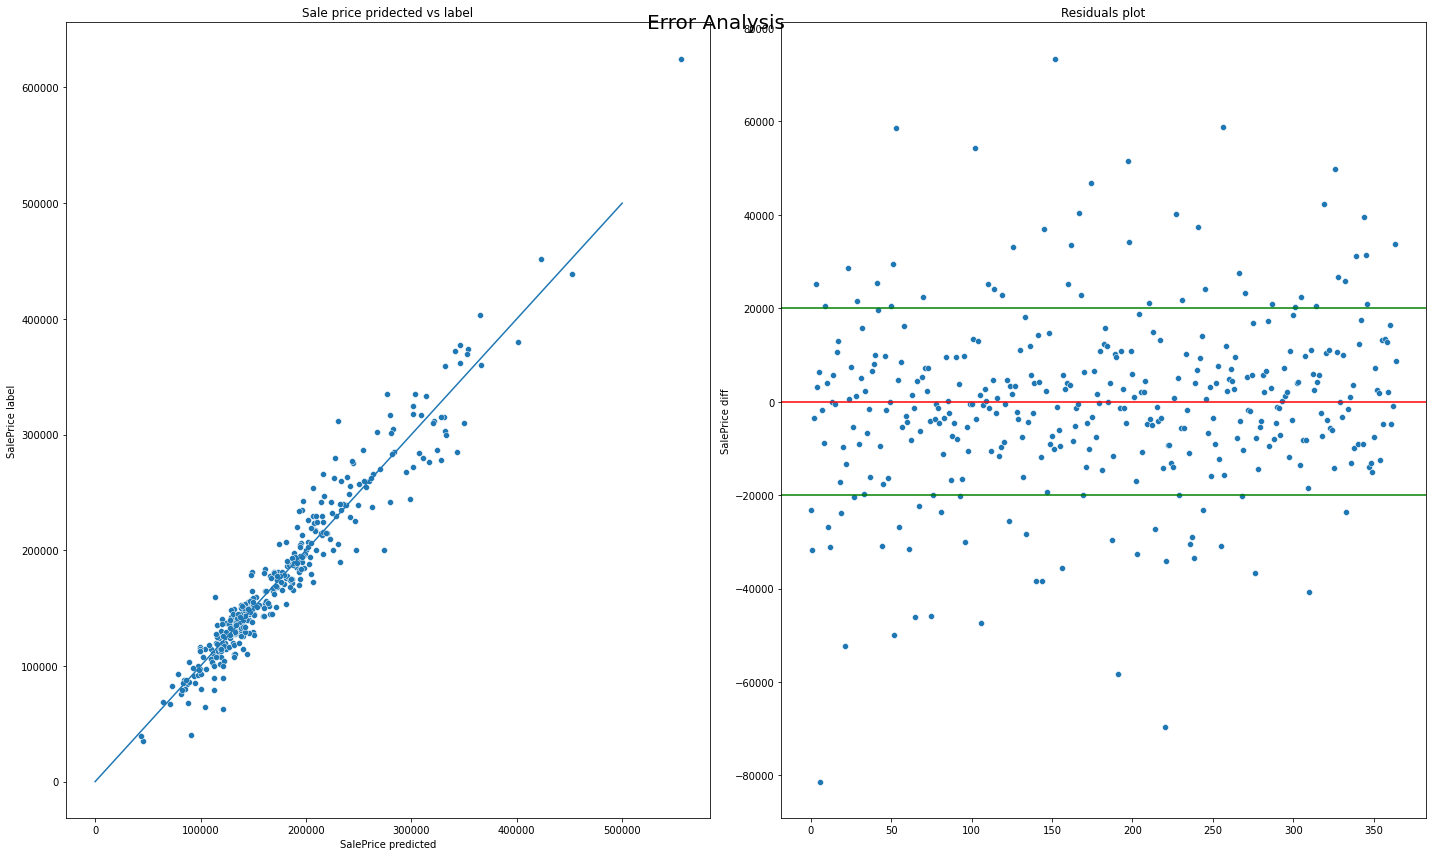

In [293]:
error_analysis(y_test, preds)


In [294]:
pd.DataFrame({"importance": model.feature_importances_, "feature": model.feature_names_}).sort_values(by="importance", ascending=False)

,importance,feature
29,18.496998,GrLivArea
51,15.113453,NeighborhoodOrdinal
8,14.031112,OverallQual
16,6.342957,ExterQual
21,4.613839,BsmtFinSF1
24,3.720634,TotalBsmtSF
27,3.680256,1stFlrSF
17,3.673325,BsmtQual
41,3.549770,GarageCars
34,3.460004,KitchenQual


### Optimization

In [37]:
hyper_params = {
    "depth": [2, 3],
    "iterations": [1000, 1500, 2000, 2500, 3000, 4000],
    "l2_leaf_reg": [10, 50, 100],
    "bootstrap_type": ["Bernoulli", "MVS"],
    "grow_policy": ["SymmetricTree", "Depthwise"],
    "min_child_samples": [50, 100],
    "subsample": [0.6],
    "random_strength": [1],
    "one_hot_max_size": [30]
}

cat_features, num_features = extract_cat_features(train_aggregation)
X_train, y_train = prepare_and_split_data(train_aggregation, test_size=0)
X_train.shape

(1457, 52)

In [38]:
cat_features, num_features = extract_cat_features(train_aggregation)
X_train, y_train = prepare_and_split_data(train_aggregation, test_size=0)

catboost_model = CatBoostRegressor(cat_features=cat_features, loss_function="RMSE", verbose=100)

clf = GridSearchCV(estimator=catboost_model, param_grid=hyper_params, scoring='neg_mean_squared_log_error', cv=5, verbose=10)

clf.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
1300:	learn: 18737.3277351	total: 1.38s	remaining: 1.8s
1400:	learn: 18351.2716653	total: 1.5s	remaining: 1.72s
1500:	learn: 17985.6647827	total: 1.6s	remaining: 1.6s
1600:	learn: 17622.3652562	total: 1.71s	remaining: 1.49s
1700:	learn: 17348.1571763	total: 1.81s	remaining: 1.38s
1800:	learn: 17105.2536112	total: 1.91s	remaining: 1.27s
1900:	learn: 16818.4552103	total: 2.01s	remaining: 1.16s
2000:	learn: 16596.1964028	total: 2.12s	remaining: 1.06s
2100:	learn: 16355.5995816	total: 2.21s	remaining: 947ms
2200:	learn: 16120.1432302	total: 2.31s	remaining: 840ms
2300:	learn: 15905.0950572	total: 2.44s	remaining: 743ms
2400:	learn: 15691.6152702	total: 2.56s	remaining: 639ms
2500:	learn: 15500.8709155	total: 2.66s	remaining: 531ms
2600:	learn: 15323.8627859	total: 2.77s	remaining: 425ms
2700:	learn: 15144.3568938	total: 2.87s	remaining: 317ms
2800:	learn: 15004.0164225	total: 2.98s	remaining: 212ms
2900:	learn: 14841.8073367	total: 3.08s	r

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.8/dist-packages/catboost/core.py", line 2339, in _fit
    train_para

100:	learn: 30241.6537205	total: 110ms	remaining: 3.17s
200:	learn: 24065.1024781	total: 258ms	remaining: 3.59s
300:	learn: 21628.6235377	total: 365ms	remaining: 3.27s
400:	learn: 20189.7674410	total: 460ms	remaining: 2.98s
500:	learn: 19147.1453511	total: 567ms	remaining: 2.83s
600:	learn: 18381.3185171	total: 665ms	remaining: 2.65s
700:	learn: 17721.0898502	total: 791ms	remaining: 2.59s
800:	learn: 17167.0203224	total: 901ms	remaining: 2.47s
900:	learn: 16671.5657179	total: 1s	remaining: 2.34s
1000:	learn: 16284.7522422	total: 1.1s	remaining: 2.2s
1100:	learn: 15883.3648993	total: 1.2s	remaining: 2.07s
1200:	learn: 15524.3315528	total: 1.3s	remaining: 1.95s
1300:	learn: 15213.2096289	total: 1.41s	remaining: 1.83s
1400:	learn: 14893.3602034	total: 1.51s	remaining: 1.72s
1500:	learn: 14589.0634985	total: 1.61s	remaining: 1.61s
1600:	learn: 14314.0171909	total: 1.71s	remaining: 1.5s
1700:	learn: 14045.0325373	total: 1.83s	remaining: 1.4s
1800:	learn: 13798.9635377	total: 1.93s	remaining

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe180039b20>,
             param_grid={'bootstrap_type': ['Bernoulli', 'MVS', 'Bayesian'],
                         'depth': [2, 3],
                         'grow_policy': ['SymmetricTree', 'Depthwise'],
                         'iterations': [1000, 1500, 2000, 2500, 3000],
                         'l2_leaf_reg': [10, 50, 100],
                         'min_child_samples': [50, 100],
                         'one_hot_max_size': [30], 'random_strength': [1],
                         'subsample': [0.6]},
             scoring='neg_mean_squared_log_error', verbose=10)

In [44]:
clf.best_params_

{'bootstrap_type': 'Bernoulli',
 'depth': 3,
 'grow_policy': 'SymmetricTree',
 'iterations': 3000,
 'l2_leaf_reg': 10,
 'min_child_samples': 50,
 'one_hot_max_size': 30,
 'random_strength': 1,
 'subsample': 0.6}

## Test Submission

### Prepare Test Data


In [51]:
test = fill_missing_values(test_data)

test.drop(['Id', 'LotFrontage', 'Utilities'], inplace=True, axis=1)

for col in test.columns:
    if test[col].unique().any() in ['TA', 'Gd', 'Fa', 'Po', 'Ex']:
        test[col] = test[col].map(mapping)

test['FireplaceQu'] = test['FireplaceQu'].map(mapping)

for i, n in enumerate(n_sorted):
    test.loc[test['Neighborhood'] == n, 'NeighborhoodOrdinal'] = int(i+1)

test['GarageCars'] = test['GarageCars'].apply(lambda x: x if x <=3 else 3).astype(int)
test['Fireplaces'] = test['Fireplaces'].apply(lambda x: x if x <=3 else 3).astype(int)
test.drop([*(catboost_feature_importance['feature'][-20:])], axis=1, inplace=True)
test.drop(['GarageArea', 'TotRmsAbvGrd', 'BsmtFinType2', 'Condition2', 'MasVnrType', '3SsnPorch'], axis=1, inplace=True)


In [52]:
test[ ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenQual' ]] = test.loc[:, ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenQual']].fillna(0.0)

test['SaleType'] = test.loc[:, ['SaleType']].fillna('WD')
test['Exterior1st'] = test.loc[:, ['Exterior1st']].fillna('VinylSd')
test['Exterior2nd'] = test.loc[:, ['Exterior2nd']].fillna('VinylSd')
test['Functional'] = test.loc[:, ['Functional']].fillna('Typ')
test['MSZoning'] = test.loc[:, ['MSZoning']].fillna('RL')





In [54]:
final_model = CatBoostRegressor(**clf.best_params_,
                                loss_function="MAE",
                                verbose=100)

cat_features, num_features = extract_cat_features(train_aggregation)
X_train, X_test, y_train, y_test = prepare_and_split_data(train_aggregation, test_size=0.2)


# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

final_model.fit(train_pool, eval_set=eval_pool)

0:	learn: 53763.1940114	test: 56299.4589245	best: 56299.4589245 (0)	total: 1.29ms	remaining: 3.86s
100:	learn: 20306.6262060	test: 22101.9740120	best: 22101.9740120 (100)	total: 110ms	remaining: 3.16s
200:	learn: 15958.5761308	test: 17475.0436175	best: 17475.0436175 (200)	total: 222ms	remaining: 3.09s
300:	learn: 13780.3704202	test: 15111.4132934	best: 15111.4132934 (300)	total: 333ms	remaining: 2.99s
400:	learn: 12642.9757471	test: 14216.1046144	best: 14213.0013877 (398)	total: 448ms	remaining: 2.9s
500:	learn: 11957.0717362	test: 13883.4523262	best: 13883.4523262 (500)	total: 563ms	remaining: 2.81s
600:	learn: 11447.3714207	test: 13641.9054614	best: 13641.9054614 (600)	total: 700ms	remaining: 2.79s
700:	learn: 10981.8494206	test: 13498.4211514	best: 13498.4211514 (700)	total: 804ms	remaining: 2.64s
800:	learn: 10650.3521257	test: 13401.3419351	best: 13398.4109344 (798)	total: 916ms	remaining: 2.51s
900:	learn: 10362.9864742	test: 13362.3339154	best: 13359.6356845 (899)	total: 1.04s	r

In [55]:
submissions_predictions = final_model.predict(test)
test_predictions = pd.DataFrame({'Id': test_data['Id'], 'SalePrice':submissions_predictions})
test_predictions.to_csv("sample_submission.csv", index=False)